In [47]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
%matplotlib inline
from torch.utils.data import Dataset, DataLoader
import torch
import torchvision

import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [48]:
m = 100                     # 5, 50, 100, 500, 2000

In [49]:
train_size = 2000           # 100, 500, 2000, 10000

In [50]:
desired_num = train_size + 1000

In [51]:
tr_i = 0
tr_j = train_size
tr_k = desired_num

tr_i, tr_j, tr_k

(0, 2000, 3000)

# Generate dataset

In [52]:
np.random.seed(1)

y = np.concatenate((np.zeros(500),np.ones(500),np.ones(500)*2,np.ones(500)*3,np.ones(500)*4,
                    np.ones(500)*5,np.ones(500)*6,np.ones(500)*7,np.ones(500)*8,np.ones(500)*9))
#y = np.random.randint(0,3,6000)
idx= []
for i in range(10):
    print(i,sum(y==i))
    idx.append(y==i)

0 500
1 500
2 500
3 500
4 500
5 500
6 500
7 500
8 500
9 500


In [53]:
x = np.zeros((5000,5))

In [54]:
np.random.seed(1)
cov_mat = [[0.1,0,0,0,0],[0,0.1,0,0,0],[0,0,0.1,0,0], [0,0,0,0.1,0],[0,0,0,0,0.1]]
x[idx[0],:] = np.random.multivariate_normal(mean = [1,0,0,0,0], cov=cov_mat,size=sum(idx[0]))
x[idx[1],:] = np.random.multivariate_normal(mean = [0,1,0,0,0], cov=cov_mat,size=sum(idx[1]))
x[idx[2],:] = np.random.multivariate_normal(mean = [0,0,1,0,0], cov=cov_mat,size=sum(idx[2]))
x[idx[3],:] = np.random.multivariate_normal(mean = [0,0,0,-0.75,0.5], cov=cov_mat,size=sum(idx[3]))
x[idx[4],:] = np.random.multivariate_normal(mean = [0,0,0,0.65,-0.65], cov=cov_mat,size=sum(idx[4]))
x[idx[5],:] = np.random.multivariate_normal(mean = [0,0,0,-0.9,-0.75], cov=cov_mat,size=sum(idx[5]))
x[idx[6],:] = np.random.multivariate_normal(mean = [0,0,0,0.8,-0.8], cov=cov_mat,size=sum(idx[6]))
x[idx[7],:] = np.random.multivariate_normal(mean = [0,0,0,-0.5,0.8], cov=cov_mat,size=sum(idx[7]))
x[idx[8],:] = np.random.multivariate_normal(mean = [0,0,0,0.9,0.75], cov=cov_mat,size=sum(idx[8]))
x[idx[9],:] = np.random.multivariate_normal(mean = [0,0,0,-1,0.65], cov=cov_mat,size=sum(idx[9]))

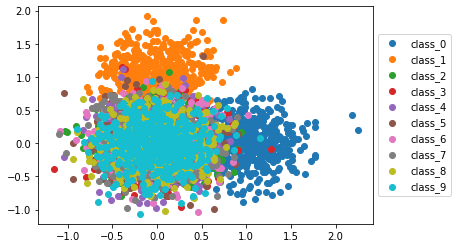

In [55]:
plt.scatter(x[idx[0],0],x[idx[0],1],label="class_"+str(0))
plt.scatter(x[idx[1],0],x[idx[1],1],label="class_"+str(1))
plt.scatter(x[idx[2],0],x[idx[2],1],label="class_"+str(2))
plt.scatter(x[idx[3],0],x[idx[3],1],label="class_"+str(3))
plt.scatter(x[idx[4],0],x[idx[4],1],label="class_"+str(4))
plt.scatter(x[idx[5],0],x[idx[5],1],label="class_"+str(5))
plt.scatter(x[idx[6],0],x[idx[6],1],label="class_"+str(6))
plt.scatter(x[idx[7],0],x[idx[7],1],label="class_"+str(7))
plt.scatter(x[idx[8],0],x[idx[8],1],label="class_"+str(8))
plt.scatter(x[idx[9],0],x[idx[9],1],label="class_"+str(9))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [56]:
print(np.mean(x)),print(np.std(x))

0.05596850080844234
0.5600574393874016


(None, None)

In [57]:
bg_idx = [ np.where(idx[3] == True)[0], 
          np.where(idx[4] == True)[0], 
          np.where(idx[5] == True)[0],
          np.where(idx[6] == True)[0], 
          np.where(idx[7] == True)[0], 
          np.where(idx[8] == True)[0],
          np.where(idx[9] == True)[0]]

bg_idx = np.concatenate(bg_idx, axis = 0)
bg_idx.shape

(3500,)

In [58]:
np.unique(bg_idx).shape

(3500,)

In [59]:
x = x - np.mean(x[bg_idx], axis = 0, keepdims = True)


In [60]:
np.mean(x[bg_idx], axis = 0, keepdims = True), np.mean(x, axis = 0, keepdims = True)

(array([[-3.07531778e-17,  3.07690381e-18,  9.78582295e-18,
         -2.26485497e-17, -2.75144986e-16]]),
 array([[ 0.10040806,  0.10206754,  0.10119494,  0.03588505, -0.02785048]]))

In [61]:
x = x/np.std(x[bg_idx], axis = 0, keepdims = True)

In [62]:
np.std(x[bg_idx], axis = 0, keepdims = True), np.std(x, axis = 0, keepdims = True)

(array([[1., 1., 1., 1., 1.]]),
 array([[1.37345756, 1.36602984, 1.38711498, 0.86420937, 0.87049227]]))

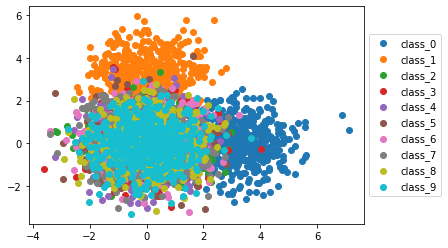

In [63]:
plt.scatter(x[idx[0],0],x[idx[0],1],label="class_"+str(0))
plt.scatter(x[idx[1],0],x[idx[1],1],label="class_"+str(1))
plt.scatter(x[idx[2],0],x[idx[2],1],label="class_"+str(2))
plt.scatter(x[idx[3],0],x[idx[3],1],label="class_"+str(3))
plt.scatter(x[idx[4],0],x[idx[4],1],label="class_"+str(4))
plt.scatter(x[idx[5],0],x[idx[5],1],label="class_"+str(5))
plt.scatter(x[idx[6],0],x[idx[6],1],label="class_"+str(6))
plt.scatter(x[idx[7],0],x[idx[7],1],label="class_"+str(7))
plt.scatter(x[idx[8],0],x[idx[8],1],label="class_"+str(8))
plt.scatter(x[idx[9],0],x[idx[9],1],label="class_"+str(9))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [64]:
foreground_classes = {'class_0','class_1', 'class_2'}

background_classes = {'class_3','class_4', 'class_5', 'class_6','class_7', 'class_8', 'class_9'}

In [65]:
fg_class  = np.random.randint(0,3)
fg_idx = np.random.randint(0,m)

a = []
for i in range(m):
    if i == fg_idx:
        b = np.random.choice(np.where(idx[fg_class]==True)[0],size=1)
        a.append(x[b])
        print("foreground "+str(fg_class)+" present at " + str(fg_idx))
    else:
        bg_class = np.random.randint(3,10)
        b = np.random.choice(np.where(idx[bg_class]==True)[0],size=1)
        a.append(x[b])
        print("background "+str(bg_class)+" present at " + str(i))
a = np.concatenate(a,axis=0)
print(a.shape)

print(fg_class , fg_idx)

background 3 present at 0
background 9 present at 1
background 8 present at 2
background 5 present at 3
background 9 present at 4
background 9 present at 5
background 3 present at 6
background 7 present at 7
background 3 present at 8
background 7 present at 9
background 9 present at 10
background 6 present at 11
background 8 present at 12
background 7 present at 13
background 9 present at 14
background 5 present at 15
background 3 present at 16
background 6 present at 17
background 4 present at 18
background 4 present at 19
background 3 present at 20
background 5 present at 21
background 8 present at 22
background 3 present at 23
background 6 present at 24
background 9 present at 25
background 8 present at 26
background 4 present at 27
background 6 present at 28
background 6 present at 29
background 3 present at 30
background 4 present at 31
background 9 present at 32
background 3 present at 33
background 6 present at 34
background 9 present at 35
background 7 present at 36
background 

In [66]:
np.reshape(a,(5*m,1))

array([[-0.47251198],
       [ 0.39952002],
       [-0.66331996],
       [-0.62701515],
       [-0.26079519],
       [ 1.19147045],
       [-0.17066575],
       [ 2.07241536],
       [-0.83269959],
       [ 1.36835129],
       [ 0.66297358],
       [-0.33581588],
       [-1.50640568],
       [ 1.8574525 ],
       [ 1.31463991],
       [-0.67590729],
       [-0.10279299],
       [-1.51747502],
       [-0.91173079],
       [-2.12361473],
       [-0.9747852 ],
       [-1.7634849 ],
       [-0.83877375],
       [-1.45184546],
       [ 0.7953278 ],
       [-0.35660586],
       [ 0.11044144],
       [-0.02043493],
       [-1.04662521],
       [ 1.54321778],
       [ 1.08131316],
       [ 1.14651002],
       [ 0.75845239],
       [-0.52639476],
       [ 0.48028221],
       [ 0.66026926],
       [-0.16235624],
       [ 0.32504969],
       [-0.72585905],
       [ 0.23673303],
       [ 1.0943025 ],
       [-1.173274  ],
       [ 1.84087674],
       [-0.29852892],
       [ 0.67286934],
       [-1

In [67]:

mosaic_list_of_images =[]
mosaic_label = []
fore_idx=[]
for j in range(desired_num):
    np.random.seed(j)
    fg_class  = np.random.randint(0,3)
    fg_idx = np.random.randint(0,m)
    a = []
    for i in range(m):
        if i == fg_idx:
            b = np.random.choice(np.where(idx[fg_class]==True)[0],size=1)
            a.append(x[b])
#             print("foreground "+str(fg_class)+" present at " + str(fg_idx))
        else:
            bg_class = np.random.randint(3,10)
            b = np.random.choice(np.where(idx[bg_class]==True)[0],size=1)
            a.append(x[b])
#             print("background "+str(bg_class)+" present at " + str(i))
    a = np.concatenate(a,axis=0)
    mosaic_list_of_images.append(np.reshape(a,(5*m,1)))
    mosaic_label.append(fg_class)
    fore_idx.append(fg_idx)

In [68]:
mosaic_list_of_images = np.concatenate(mosaic_list_of_images,axis=1).T
mosaic_list_of_images.shape

(3000, 500)

In [69]:
mosaic_list_of_images.shape, mosaic_list_of_images[0]

((3000, 500),
 array([-0.81036338, -1.69010846, -0.32834992,  1.29702234,  0.53276238,
        -0.79420497, -0.04599438, -0.978943  ,  1.73876522, -1.3450371 ,
        -0.43436229, -0.11380089, -1.58617926,  1.2449917 , -1.12361098,
         1.56683597, -0.19620249, -0.69279456,  1.35084787, -0.61869265,
        -0.17571755,  0.78432295, -2.38902264,  1.35982869,  0.16741467,
         0.16034862, -1.00277567,  0.66775357, -0.60586546,  1.10921126,
        -0.44812413, -0.67671916, -1.53098362, -1.62153413,  0.96433   ,
        -0.44651283,  1.3865734 , -0.223064  , -0.77373608,  0.46991444,
         1.36994422,  0.51053141, -0.41562254, -0.48028085, -0.82167715,
         0.04860186,  0.58962855, -0.35582799, -1.46433256,  0.84083752,
         0.45287991, -0.26291736, -1.18417584, -1.03863174,  1.02989593,
        -1.84078239, -1.19258202, -1.42305443,  1.15897324, -1.48621764,
        -0.84729321, -1.23426332,  1.18676516,  0.48049517, -1.06420592,
        -0.10153338, -0.30107614, -0.

In [70]:
for j in range(m):
  print(mosaic_list_of_images[0][5*j:5*j+5])
  

[-0.81036338 -1.69010846 -0.32834992  1.29702234  0.53276238]
[-0.79420497 -0.04599438 -0.978943    1.73876522 -1.3450371 ]
[-0.43436229 -0.11380089 -1.58617926  1.2449917  -1.12361098]
[ 1.56683597 -0.19620249 -0.69279456  1.35084787 -0.61869265]
[-0.17571755  0.78432295 -2.38902264  1.35982869  0.16741467]
[ 0.16034862 -1.00277567  0.66775357 -0.60586546  1.10921126]
[-0.44812413 -0.67671916 -1.53098362 -1.62153413  0.96433   ]
[-0.44651283  1.3865734  -0.223064   -0.77373608  0.46991444]
[ 1.36994422  0.51053141 -0.41562254 -0.48028085 -0.82167715]
[ 0.04860186  0.58962855 -0.35582799 -1.46433256  0.84083752]
[ 0.45287991 -0.26291736 -1.18417584 -1.03863174  1.02989593]
[-1.84078239 -1.19258202 -1.42305443  1.15897324 -1.48621764]
[-0.84729321 -1.23426332  1.18676516  0.48049517 -1.06420592]
[-0.10153338 -0.30107614 -0.73419762 -0.53748843  0.51291702]
[-0.12205826  0.8901293   1.10989224  0.01840723  0.82950128]
[-1.14814773 -1.42257382 -1.2890686  -1.00033703  1.42714313]
[-1.1009

In [71]:
def create_avg_image_from_mosaic_dataset(mosaic_dataset,labels,foreground_index,dataset_number, m):
  """
  mosaic_dataset : mosaic_dataset contains 9 images 32 x 32 each as 1 data point
  labels : mosaic_dataset labels
  foreground_index : contains list of indexes where foreground image is present so that using this we can take weighted average
  dataset_number : will help us to tell what ratio of foreground image to be taken. for eg: if it is "j" then fg_image_ratio = j/9 , bg_image_ratio = (9-j)/8*9
  """
  avg_image_dataset = []
  cnt = 0
  counter = np.zeros(m) #np.array([0,0,0,0,0,0,0,0,0])
  for i in range(len(mosaic_dataset)):
    img = torch.zeros([5], dtype=torch.float64)
    np.random.seed(int(dataset_number*10000 + i))
    give_pref = foreground_index[i] #np.random.randint(0,9)
    # print("outside", give_pref,foreground_index[i])
    for j in range(m):
      if j == give_pref:
        img = img + mosaic_dataset[i][5*j:5*j+5]*dataset_number/m   #2 is data dim
      else :
        img = img + mosaic_dataset[i][5*j:5*j+5]*(m-dataset_number)/((m-1)*m)

    if give_pref == foreground_index[i] :
      # print("equal are", give_pref,foreground_index[i])
      cnt += 1
      counter[give_pref] += 1
    else :
      counter[give_pref] += 1

    avg_image_dataset.append(img)

  print("number of correct averaging happened for dataset "+str(dataset_number)+" is "+str(cnt)) 
  print("the averaging are done as ", counter) 
  return avg_image_dataset , labels , foreground_index
        
  

In [72]:
avg_image_dataset_1 , labels_1,  fg_index_1 = create_avg_image_from_mosaic_dataset(mosaic_list_of_images[0:tr_j], mosaic_label[0:tr_j], fore_idx[0:tr_j] , 1, m)


test_dataset , labels , fg_index = create_avg_image_from_mosaic_dataset(mosaic_list_of_images[tr_j : tr_k], mosaic_label[tr_j : tr_k], fore_idx[tr_j : tr_k] , m, m)

number of correct averaging happened for dataset 1 is 2000
the averaging are done as  [23. 16. 20. 22. 16. 20. 19. 22. 10. 21. 15. 20. 21. 15. 15. 28. 24. 27.
 20. 25. 24. 15. 16. 21. 20. 21. 31. 19. 28. 20. 30. 15. 18. 19. 21. 26.
  9. 21. 18. 15. 20. 25. 13. 19. 14. 18. 28. 12. 17. 21. 19. 18. 18. 16.
 22. 22. 22. 22. 24. 11. 19. 22. 25. 18. 29. 20. 27.  8. 19. 22. 25. 19.
 18. 16. 19. 17. 24. 20. 21. 21. 30. 21. 16. 17. 20. 16. 26. 22. 13. 17.
 22. 16. 26. 20. 21. 24. 15. 16. 22. 24.]
number of correct averaging happened for dataset 100 is 1000
the averaging are done as  [10.  8.  9.  6. 13.  9. 10. 11. 10. 13. 13.  6.  8. 15. 12. 11.  7.  9.
 11.  7. 12. 10. 10. 10. 11. 15.  8. 10. 11. 14. 10. 13.  8.  9.  6. 10.
 11. 10.  9.  9.  8. 10.  9. 12. 10. 13.  7.  4.  8. 10.  9.  5. 14. 12.
  6.  5. 11.  8.  5.  9. 11. 12. 16.  9.  9.  3. 10.  9. 10. 10.  9.  6.
  9. 15. 10. 11.  2. 17. 14.  9. 10. 10. 16. 13.  8. 15. 11.  8.  9. 11.
  4. 12. 14. 11.  7.  7. 17.  9. 15. 13.]


In [73]:
avg_image_dataset_1 = torch.stack(avg_image_dataset_1, axis = 0)
# avg_image_dataset_1 = (avg - torch.mean(avg, keepdims= True, axis = 0)) / torch.std(avg, keepdims= True, axis = 0)
# print(torch.mean(avg_image_dataset_1, keepdims= True, axis = 0))
# print(torch.std(avg_image_dataset_1, keepdims= True, axis = 0))
print("=="*40)


test_dataset = torch.stack(test_dataset, axis = 0)
# test_dataset = (avg - torch.mean(avg, keepdims= True, axis = 0)) / torch.std(avg, keepdims= True, axis = 0)
# print(torch.mean(test_dataset, keepdims= True, axis = 0))
# print(torch.std(test_dataset, keepdims= True, axis = 0))
print("=="*40)


Text(0.5, 1.0, 'dataset4 CIN with alpha = 1/100')

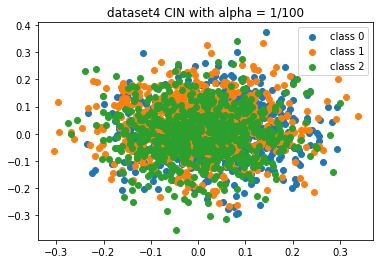

In [74]:
x1 = (avg_image_dataset_1).numpy()
y1 = np.array(labels_1)

plt.scatter(x1[y1==0,0], x1[y1==0,1], label='class 0')
plt.scatter(x1[y1==1,0], x1[y1==1,1], label='class 1')
plt.scatter(x1[y1==2,0], x1[y1==2,1], label='class 2')
plt.legend()
plt.title("dataset4 CIN with alpha = 1/"+str(m))

Text(0.5, 1.0, 'test dataset4')

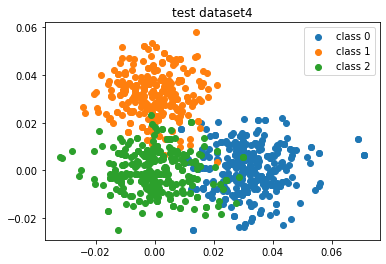

In [75]:
x1 = (test_dataset).numpy() / m
y1 = np.array(labels)

plt.scatter(x1[y1==0,0], x1[y1==0,1], label='class 0')
plt.scatter(x1[y1==1,0], x1[y1==1,1], label='class 1')
plt.scatter(x1[y1==2,0], x1[y1==2,1], label='class 2')
plt.legend()
plt.title("test dataset4")

In [76]:
test_dataset[0:10]/m

tensor([[-0.0026,  0.0029,  0.0329,  0.0029, -0.0102],
        [ 0.0285, -0.0132,  0.0114, -0.0010, -0.0062],
        [ 0.0056,  0.0281, -0.0225, -0.0044,  0.0022],
        [ 0.0328,  0.0052, -0.0031, -0.0038, -0.0065],
        [-0.0089,  0.0111,  0.0207, -0.0015,  0.0015],
        [ 0.0076,  0.0218,  0.0011, -0.0045, -0.0108],
        [ 0.0240, -0.0043,  0.0010,  0.0047, -0.0008],
        [ 0.0004,  0.0207,  0.0058,  0.0049,  0.0038],
        [-0.0130, -0.0078,  0.0113,  0.0082, -0.0068],
        [ 0.0037,  0.0015,  0.0293, -0.0020,  0.0004]], dtype=torch.float64)

In [77]:
test_dataset = test_dataset/m
test_dataset[0:10]

tensor([[-0.0026,  0.0029,  0.0329,  0.0029, -0.0102],
        [ 0.0285, -0.0132,  0.0114, -0.0010, -0.0062],
        [ 0.0056,  0.0281, -0.0225, -0.0044,  0.0022],
        [ 0.0328,  0.0052, -0.0031, -0.0038, -0.0065],
        [-0.0089,  0.0111,  0.0207, -0.0015,  0.0015],
        [ 0.0076,  0.0218,  0.0011, -0.0045, -0.0108],
        [ 0.0240, -0.0043,  0.0010,  0.0047, -0.0008],
        [ 0.0004,  0.0207,  0.0058,  0.0049,  0.0038],
        [-0.0130, -0.0078,  0.0113,  0.0082, -0.0068],
        [ 0.0037,  0.0015,  0.0293, -0.0020,  0.0004]], dtype=torch.float64)

In [78]:
test_dataset.shape

torch.Size([1000, 5])

In [79]:
class MosaicDataset(Dataset):
  """MosaicDataset dataset."""

  def __init__(self, mosaic_list_of_images, mosaic_label):
    """
      Args:
        csv_file (string): Path to the csv file with annotations.
        root_dir (string): Directory with all the images.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.mosaic = mosaic_list_of_images
    self.label = mosaic_label
    #self.fore_idx = fore_idx
    
  def __len__(self):
    return len(self.label)

  def __getitem__(self, idx):
    return self.mosaic[idx] , self.label[idx] #, self.fore_idx[idx]



In [80]:
avg_image_dataset_1[0].shape
avg_image_dataset_1[0]

tensor([-0.1105,  0.0029, -0.0547, -0.0722, -0.0597], dtype=torch.float64)

In [81]:
batch = 200

traindata_1 = MosaicDataset(avg_image_dataset_1, labels_1 )
trainloader_1 = DataLoader( traindata_1 , batch_size= batch ,shuffle=True)


In [82]:
testdata_1 = MosaicDataset(test_dataset, labels )
testloader_1 = DataLoader( testdata_1 , batch_size= batch ,shuffle=False)


In [83]:
# testdata_11 = MosaicDataset(test_dataset, labels )
# testloader_11 = DataLoader( testdata_11 , batch_size= batch ,shuffle=False)

In [84]:
class Whatnet(nn.Module):
    def __init__(self):
        super(Whatnet,self).__init__()
        self.linear1 = nn.Linear(5,3)
        # self.linear2 = nn.Linear(50,3)

        torch.nn.init.xavier_normal_(self.linear1.weight)
        torch.nn.init.zeros_(self.linear1.bias)
        # torch.nn.init.xavier_normal_(self.linear2.weight)
        # torch.nn.init.zeros_(self.linear2.bias)

    def forward(self,x):
        # x = F.relu(self.linear1(x))
        x = (self.linear1(x))

        return x

In [85]:
def calculate_loss(dataloader,model,criter):
  model.eval()
  r_loss = 0
  with torch.no_grad():
    for i, data in enumerate(dataloader, 0):
      inputs, labels = data
      inputs, labels = inputs.to("cuda"),labels.to("cuda")
      outputs = model(inputs)
      loss = criter(outputs, labels)
      r_loss += loss.item()
  return r_loss/(i+1)

In [86]:
def test_all(number, testloader,net):
    correct = 0
    total = 0
    out = []
    pred = []
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to("cuda"),labels.to("cuda")
            out.append(labels.cpu().numpy())
            outputs= net(images)
            _, predicted = torch.max(outputs.data, 1)
            pred.append(predicted.cpu().numpy())
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    pred = np.concatenate(pred, axis = 0)
    out = np.concatenate(out, axis = 0)
    print("unique out: ",  np.unique(out), "unique pred: ", np.unique(pred) )
    print("correct: ", correct, "total ",  total)
    print('Accuracy of the network on the %d test dataset %d: %.2f %%' % (total, number , 100 * correct / total))

In [87]:
def train_all(trainloader, ds_number, testloader_list, lr_list):
  
  final_loss = []
  for LR in lr_list:    
    print("--"*20, "Learning Rate used is", LR)
    
    torch.manual_seed(12)
    net = Whatnet().double()
    net = net.to("cuda")
    
    criterion_net = nn.CrossEntropyLoss()
    optimizer_net = optim.Adam(net.parameters(), lr=LR ) #, momentum=0.9)
    
    acti = []
    loss_curi = []
    epochs = 1000
    running_loss = calculate_loss(trainloader,net,criterion_net)
    loss_curi.append(running_loss)
    print('epoch: [%d ] loss: %.3f' %(0,running_loss)) 
    for epoch in range(epochs): # loop over the dataset multiple times
        ep_lossi = []

        running_loss = 0.0
        net.train()
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data
            inputs, labels = inputs.to("cuda"),labels.to("cuda")

            # zero the parameter gradients
            optimizer_net.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion_net(outputs, labels)
            # print statistics
            running_loss += loss.item()
            loss.backward()
            optimizer_net.step()

        running_loss = calculate_loss(trainloader,net,criterion_net)
        if(epoch%200 == 0):
          print('epoch: [%d] loss: %.3f' %(epoch + 1,running_loss)) 
        loss_curi.append(running_loss)   #loss per epoch
        if running_loss<=0.05:
          print('epoch: [%d] loss: %.3f' %(epoch + 1,running_loss))
          break

    print('Finished Training')
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in trainloader:
            images, labels = data
            images, labels = images.to("cuda"), labels.to("cuda")
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the %d train images: %.2f %%' % (total,  100 * correct / total))
    
    for i, j in enumerate(testloader_list):
        test_all(i+1, j,net)
    
    print("--"*40)
    
    final_loss.append(loss_curi) 
  return final_loss
    

In [88]:
train_loss_all=[]

testloader_list= [ testloader_1]
lr_list = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5 ]

In [89]:
fin_loss = train_all(trainloader_1, 1, testloader_list, lr_list)
train_loss_all.append(fin_loss)

---------------------------------------- Learning Rate used is 0.0001
epoch: [0 ] loss: 1.118
epoch: [1] loss: 1.118
epoch: [201] loss: 1.109
epoch: [401] loss: 1.101
epoch: [601] loss: 1.094
epoch: [801] loss: 1.088
Finished Training
Accuracy of the network on the 2000 train images: 41.30 %
unique out:  [0 1 2] unique pred:  [0 1 2]
correct:  825 total  1000
Accuracy of the network on the 1000 test dataset 1: 82.50 %
--------------------------------------------------------------------------------
---------------------------------------- Learning Rate used is 0.0005
epoch: [0 ] loss: 1.118
epoch: [1] loss: 1.118
epoch: [201] loss: 1.084
epoch: [401] loss: 1.071
epoch: [601] loss: 1.066
epoch: [801] loss: 1.065
Finished Training
Accuracy of the network on the 2000 train images: 42.90 %
unique out:  [0 1 2] unique pred:  [0 1 2]
correct:  975 total  1000
Accuracy of the network on the 1000 test dataset 1: 97.50 %
---------------------------------------------------------------------------

In [90]:
%matplotlib inline

In [91]:
len(fin_loss)

8

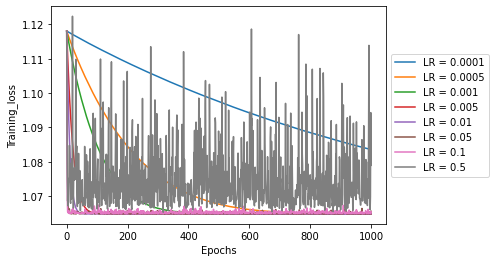

In [92]:
for i,j in enumerate(fin_loss):
    plt.plot(j,label ="LR = "+str(lr_list[i]))
    

plt.xlabel("Epochs")
plt.ylabel("Training_loss")

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))